# AI_campus_ProstateSeg 
# Module 4: Pytorch dataset class and data loaders
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

This notebook walks through using the dataset and data loader classes in PyTorch in order to process tiles from whole slide images and feed them to machine learning models. The data loader is an iterable over which batches are processed and fed into machine learning models. The PyTorch dataset class loads data from disk, processes the images in a tile by tile basis and then returns it as singular data points. The data loader wraps an iterable around the PyTorch dataset class and fetches data in batches. 

## 1. Import the necessary packages

In [250]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil
import torch

from PIL import Image
from typing import List, Union, Optional, Dict, Tuple
from torch.utils.data import Dataset

## 2. Define folder and subdirectory folder names

In [251]:
ROOT_FOLDER = "sample_data"
IMAGE_SUBFOLDER = "train_images"
MASK_SUBFOLDER = "train_label_masks"

image_dir = os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER)
mask_dir = os.path.join(ROOT_FOLDER, MASK_SUBFOLDER)

## 3. Create list of image and mask files and print contents

In [252]:
image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(image_dir))))
mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(mask_dir))))

In [253]:
image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

In [255]:
mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

Write a class to process image data on a tile by tile basis. The class will inherit from PyTorch's dataset class, and override two key dunder methods: one for the length of the dataset and the other for getting an item. 

In [328]:
class ToyPANDASDataset(Dataset):
    
    def __init__(self,
                 image_dir: str,
                 mask_dir: str, 
                 root_dir: str,
                 mask_suffix: str = "_mask",
                 imfile_ext: str = ".tiff",
                 maskfile_ext: str = ".tiff",
                 tile_size: int = 224,
                 channel_idx: int = 0,
                 min_thresh: float = 0.5,
                 transform = None,
                 norm_func = None):
        
        """
        Dataset class for Toy PANDA dataset of 10 images and masks.
        
        Parameters
        -----------
        image_dir: str
            The directory containing the images. 
        
        mask_dir: str
            The directory containing the masks paired with each of the images. 
        
        root_dir: str
            The root directory containing both the image and mask folders.
        
        mask_suffix: str
            The suffix associated with mask files in the folder. In this case,
            it is "_mask." Each image is labeled alphanumerically, and its corresponding
            mask file has a "_mask" suffix following the alphanumeric name. 
        
        imfile_ext: str
            The extension or file type of the image file. In this case, it is ".tiff"
            
        maskfile_ext: str
            The extension or file type of the mask file. In this case, it is ".tiff"
        
        tile_size: int
            The size of the square tiles to extract from images in a non-overlapping way.
            Each tile extarcted from the image will contain (tile_size ** 2) number of pixels.
        
        channel_idx: int
            Since the masks in this PANDA dataset contain 3 channels. This constant indicates
            the location of the official, 2 by 2 mask in the 3 channel mask tensor. Default
            value is 0. 
        
        min_thresh: float
            This constant sets a criteria for tile qualification. A tile is only qualified to
            be positively filtered for the dataset if it containts signal (% of foreground of all pixels)
            that is more than or equal to min_thresh.
        
        transform: Optional[None, function]
            This object stores None or a function. If it is a function, this function is applied
            to the data before being returned by the get item dunder method. This transform could
            contain a normalization function or it could contain a series of augmentation steps
            applied before returning an image. 
        
        norm_func: Optional[None, function]
            Function to normalize a tile depending on certain pre-defined 
            min-max statistics (for min max normalization) or z-score normalization
            depending on pre-defined statistics for the mean and standard deviation. 
        
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.root_dir = root_dir
        self.mask_suffix = mask_suffix
        self.imfile_ext = imfile_ext
        self.maskfile_ext = maskfile_ext
        self.transform = transform
        self.norm_func = norm_func
        self.tile_size = tile_size
        self.full_mask_ext = self.mask_suffix + self.maskfile_ext
        self.channel_idx = channel_idx
        self.image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(self.image_dir))))
        self.mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(self.mask_dir))))
        self.n_tiles_processed = 0
        self.n_qualifying_tiles = 0
        self.min_thresh = min_thresh
        self.imtile_coords = self.get_imtile_coords()
        
    def extract_raw_regid(self,
                          filename: str,
                          ext: str) -> str:
        """
        This function receives a filename which a specific
        extension like "_mask.tiff" or ".tiff", then it processes
        and returns the part of the filename up until but excluding
        the extension. 
        
        Parameters
        -----------
        filename: str
            The filename, with the name and extension as a suffix
        
        ext: str
            The extension
        
        Returns
        ----------
        The filename up until but excluding the extension
        
        """
        i = 1
        while filename[-i:] != ext:
            i += 1
        return filename[0:len(filename)-i]
    
    def tile_qualifier(self,
                       tile_mask: np.ndarray):
        """
        A tile qualifier function. This function
        receives a mask extracted from a tile. The mask
        can be binary or it could be multi-class,
        representing presence of multiple different classes
        indicated by integer values greater than or equal to 1. 
        The background (non-signal) region should be represented
        by 0. This function checks if the mask contains a minimum
        threshold of signal, as represented by the number of non-zero
        values as a percentage of the total number of pixels in the
        tile. 
        
        Parameters
        -----------
        tile_mask: np.ndarray
            A tile (square or rectangular) as a numpy array,
            containing integer values greater than or equal to 0.
        
        Returns
        ---------
        bool
            Whether the tile qualifies or not.
            Whether its signal ratio meets the minimum
            threshold requirement for it to qualify
            to be included in the dataset. 
            
        """
        
        signal_ratio = (tile_mask > 0).sum()/tile_mask.size
        
        return signal_ratio >= self.min_thresh
    
    def extract_nonoverlapping_tile_coords(self,
                                           mask: np.ndarray):
        
        """
        This function extracts nonoverlapping tile coordinates
        from a mask according to the tile_size. It collects
        the coordinates of the top left corner of each tile and 
        then returns it. 
        
        Paramters
        ---------
        mask: np.ndarray
            A mask of arbitrary shape. Containing 3 or more
            channels, but only the 0th channel is used as the
            official, signal indicating channel for extracting 
            tile coordinates.
        
        Returns
        --------
        List[Tuple[int, int]]
            A list of coordinates stored in tuples of size 2.
            These are coordinates of tiles that qualify according
            to the tile qualifier function. 
        """
        
        mask = mask[:,:,self.channel_idx]
        assert len(mask.shape) == 2
        R, C = mask.shape
        tile_coords = []
        for i in range(0, R, self.tile_size):
            for j in range(0, C, self.tile_size):
                try:
                    tile = mask[i : i + self.tile_size, j : j + self.tile_size]
                    self.n_tiles_processed += 1
                    if tile.shape == (self.tile_size, self.tile_size) and self.tile_qualifier(tile):
                        tile_coords.append((i, j))
                        self.n_qualifying_tiles += 1
                except IndexError:
                    print(f"Skipping tile at position ({i}, {j}) because it is out of bounds.")
                        
        return tile_coords
    
    def get_imtile_coords(self):
        
        """
        Function to process the images and return a list of 
        3-sized tuples that contain the name of the image file
        along with coordinates of qualifying tiles in them.
        The image file names can be repeated in tuples, but not
        the coordinate of the tiles.
        
        Parameters
        -----------
        None, all objects used are instantiated in the constructor.
        
        Returns
        -----------
        List[Tuple[str, in, int]]
            A list of tuples. The first value in the tuple is
            the name of the image file. The second and third
            values in the tuples are coordinates of one of the
            qualifying tiles in the image.
            
        """
        
        imtile_coords = []
        
        for imfile in self.image_files:
            regid = self.extract_raw_regid(imfile, self.imfile_ext)
            mask_file = regid + self.full_mask_ext
            mask = tifffile.imread(os.path.join(self.mask_dir, mask_file))
            tile_coords = self.extract_nonoverlapping_tile_coords(mask)
            imtile_coord = list(map(lambda tup : (imfile,) + tup, tile_coords))
            imtile_coords.extend(imtile_coord)
            
        self.tile_qualifying_ratio = self.n_qualifying_tiles / self.n_tiles_processed
        print(f"Total number of tiles processed: {self.n_tiles_processed}")
        print(f"Tile qualifying ratio: {self.tile_qualifying_ratio}")
        print(f"Average number of tiles processed per image or mask: {self.n_tiles_processed/len(self.image_files)}")
        print(f"Average number of tiles qualifying per image or mask: {self.n_qualifying_tiles/len(self.image_files)}")
        
        imfiles = set([t[0] for t in imtile_coords])
        assert imfiles == set(self.image_files)
        i_vals = sorted(list(set([t[1] for t in imtile_coords])))
        j_vals = sorted(list(set([t[2] for t in imtile_coords])))
        
        for i in range(len(i_vals)-1):
            assert i_vals[i + 1] - i_vals[i] == self.tile_size
        
        for j in range(len(j_vals)-1):
            assert j_vals[j + 1] - j_vals[j] == self.tile_size
            
        return imtile_coords
        
    def __len__(self):
        
        """
        Dunder method to return the length of the
        dataset. The total length of the dataset 
        is the total number of tiles over all 
        of the images. Some images may provide more
        tiles to the dataset depending on their signal
        content, while other images may provide less
        tiles if they are weak in signal.
        """
        
        return len(self.imtile_coords)
    
    def __getitem__(self, idx):
        
        """
        Function for getting a tile from the dataset.
        Given an index, it finds a tuple in the imtile_coords
        and unpacks it to retrieve the image file and the coordinates
        of one of the qualifying tiles in the image. 
        """
        
        image_file, tile_i, tile_j = self.imtile_coords[idx]
        image = tifffile.imread(os.path.join(self.image_dir, image_file))
        tile = image[tile_i: tile_i + self.tile_size, tile_j: tile_j + self.tile_size, :]
        
        if self.norm_func:
            tile = torch.tensor(tile)
            tile = tile.unsqueeze(0).permute(0, 3, 1, 2)
            tile = self.norm_func(tile)
            tile = tile.squeeze(0).permute(1,2,0)
            
        if self.transform:
            tile = self.transform(tile)
            
        return tile

Instantiate the PANDA dataset class. The class instantiation process will print out the following metrics for tile processing

- total number of tiles processed over the entire dataset
- tile qualifying ratio (the number of tiles from the total number of tiles that were processed)
- average number of tiles processed per image or mask
- average number of tiles qualifying per image or mask

In [267]:
panda_dataset = ToyPANDASDataset(image_dir = image_dir,
                                 mask_dir = mask_dir,
                                 root_dir = ROOT_FOLDER)

Total number of tiles processed: 38593
Tile qualifying ratio: 0.15458761951649264
Average number of tiles processed per image or mask: 3859.3
Average number of tiles qualifying per image or mask: 596.6


Print out the length of the dataset class, this will return the number of qualifying tiles over the entire dataset, which is the number of tuples contained in the imtile_coords list in the dataset class.

In [273]:
len(panda_dataset)

5966

Access one element of the dataset class, which will call the __getitem__ method. It returns a single, non-batched data point, which is a tile of dimensionality (224, 224, 3)

In [272]:
panda_dataset[0].shape

(224, 224, 3)

Print out the first five tuples in imtile_coords. The first element in the tuple is the name of the image file. The second and third elements of the tuple are coordinates of a qualifying tile. 

In [271]:
panda_dataset.imtile_coords[0:5]

[('0018ae58b01bdadc8e347995b69f99aa.tiff', 448, 1792),
 ('0018ae58b01bdadc8e347995b69f99aa.tiff', 448, 2016),
 ('0018ae58b01bdadc8e347995b69f99aa.tiff', 672, 1568),
 ('0018ae58b01bdadc8e347995b69f99aa.tiff', 672, 1792),
 ('0018ae58b01bdadc8e347995b69f99aa.tiff', 672, 2016)]

Print the last five tuples of imtile_coords

In [257]:
panda_dataset.imtile_coords[-5:]

[('00a26aaa82c959624d90dfb69fcf259c.tiff', 19712, 16352),
 ('00a26aaa82c959624d90dfb69fcf259c.tiff', 19936, 15232),
 ('00a26aaa82c959624d90dfb69fcf259c.tiff', 19936, 15456),
 ('00a26aaa82c959624d90dfb69fcf259c.tiff', 19936, 15680),
 ('00a26aaa82c959624d90dfb69fcf259c.tiff', 19936, 15904)]

Instantiate a dataloader class with batch size of 16 and shuffling set to True

In [212]:
panda_loader = DataLoader(panda_dataset, batch_size=16, shuffle=True)

Define an iterator over data loader and load a batch

In [213]:
data_iter = iter(panda_loader)
batch = next(data_iter)

Print the dimensionality of one of the batches. The dimensionality will be [batch_size, tile_size, tile_size, n_channels]

In [214]:
batch.shape

torch.Size([16, 224, 224, 3])

Print the dimensionality of one of the tiles in the batches

In [258]:
batch[15].shape

torch.Size([224, 224, 3])

Plot one of the tiles

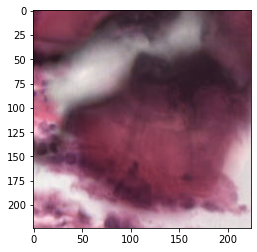

In [215]:
plt.imshow(batch[15].numpy())

The batch can be repetitively iterated over to fetch new batches

In [281]:
batch = next(data_iter)

Plot one of the tiles.

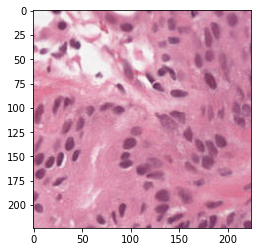

In [286]:
plt.imshow(batch[15].numpy())

Print out raw values in the image matrix

In [290]:
batch[15][0:5, 0:2]

tensor([[[245, 243, 245],
         [244, 243, 244]],

        [[245, 243, 244],
         [245, 243, 243]],

        [[246, 242, 243],
         [245, 242, 243]],

        [[246, 242, 242],
         [246, 242, 242]],

        [[245, 242, 241],
         [245, 242, 241]]], dtype=torch.uint8)

As a sanity check, we will calculate the total number of qualifying tiles and the tile qualifying ratio for the same dataset as a function of the minimum threshold. As the minimum threshold increases, we expect there to be lesser number of qualifying tiles due to the more stringent criteria applied to filter for tiles. We will create a list with 11 values for the minimum threshold, ranging from 0.01 to 0.99. We will then instiatiate the dataset classes for each minimum threshold and store the tile qualifying ratio for each value of the minimum threshold. The tile qualifying ratio is defined as follows:

$$
\text{Tile qualifying ratio} = \frac{\text{Total number of qualifying tiles}}{\text{Total number of tiles processed}}
$$

In [275]:
min_thresh_vals = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
tile_qual_ratios = []

for min_thresh in min_thresh_vals:
    
    panda_dataset = ToyPANDASDataset(image_dir = image_dir,
                                     mask_dir = mask_dir,
                                     root_dir = ROOT_FOLDER,
                                     min_thresh = min_thresh)
    
    tile_qual_ratios.append(panda_dataset.tile_qualifying_ratio)
    print("--"*50)

Total number of tiles processed: 38593
Tile qualifying ratio: 0.19026766512061774
Average number of tiles processed per image or mask: 3859.3
Average number of tiles qualifying per image or mask: 734.3
----------------------------------------------------------------------------------------------------
Total number of tiles processed: 38593
Tile qualifying ratio: 0.17920348249682586
Average number of tiles processed per image or mask: 3859.3
Average number of tiles qualifying per image or mask: 691.6
----------------------------------------------------------------------------------------------------
Total number of tiles processed: 38593
Tile qualifying ratio: 0.17236286373176482
Average number of tiles processed per image or mask: 3859.3
Average number of tiles qualifying per image or mask: 665.2
----------------------------------------------------------------------------------------------------
Total number of tiles processed: 38593
Tile qualifying ratio: 0.16679190526779467
Average n

Plot the tile qualifying ratio as a function of the different values for minimum threshold

Text(0.5, 1.0, 'Tile Qualifying Ratio as a \n function of Minimum Threshold')

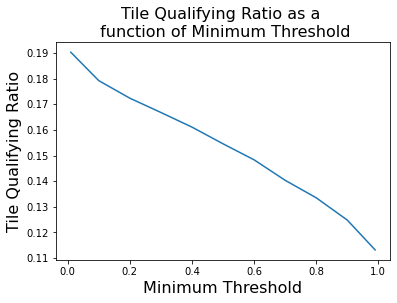

In [280]:
plt.plot(min_thresh_vals, tile_qual_ratios)
plt.xlabel("Minimum Threshold", fontsize = 16)
plt.ylabel("Tile Qualifying Ratio", fontsize = 16)
plt.title("Tile Qualifying Ratio as a \n function of Minimum Threshold", fontsize = 16)

As expected intuitively, the tile qualifying ratio decreases as a function of the minimum threshold. Higher the minimum threshold, lesser the number of tiles that qualify due to the more stringent requirements for signal ratio.

In the previous iteration of instantiating the dataset class, we did not pass in a function to normalize the tiles. In this iteration, we can pass in a function to normalize the tiles using min max normalization using the class we wrote in the earlier module on image preprocessing and normalization

Import the class to perform min max normalization from the normalizers.py module

In [285]:
from normalizers import ChannelWiseMinMaxNormalizer

Define tensors for minimum and maximum values per each of the three R, G, B channels, and instantiate the normalizer class.

In [292]:
min_vals = torch.tensor([0, 0, 0])
max_vals = torch.tensor([255, 255, 255])

normalizer = ChannelWiseMinMaxNormalizer(min_values = min_vals,
                                         max_values = max_vals)

Print the minimum and maximum value tensor attributes from the normalizer class to ensure correct instantiation

In [297]:
print(normalizer.min_values)

tensor([0, 0, 0])


In [300]:
print(normalizer.max_values)

tensor([255, 255, 255])


Instantiate the panda dataset class again, this time by passing in a method from the normalizer object into the instantiation of the panda dataset class, such that the norm_func can be applied to the tile in the get item method.

In [329]:
panda_dataset = ToyPANDASDataset(image_dir = image_dir,
                                 mask_dir = mask_dir,
                                 root_dir = ROOT_FOLDER,
                                 norm_func = normalizer.transform)

Total number of tiles processed: 38593
Tile qualifying ratio: 0.15458761951649264
Average number of tiles processed per image or mask: 3859.3
Average number of tiles qualifying per image or mask: 596.6


Now we expect the output tiles to be normalized. Print out the dimensionality of the tile returned by the get item method.

In [333]:
panda_dataset[0].shape

torch.Size([224, 224, 3])

Plot the tile. 

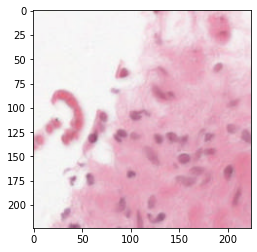

In [334]:
plt.imshow(panda_dataset[0])

Print the raw values of the tile, which will now be normalized. 

In [335]:
panda_dataset[0]

tensor([[[0.9686, 0.9686, 0.9686],
         [0.9686, 0.9686, 0.9686],
         [0.9686, 0.9686, 0.9686],
         ...,
         [0.9647, 0.9686, 0.9686],
         [0.9686, 0.9686, 0.9725],
         [0.9725, 0.9686, 0.9725]],

        [[0.9686, 0.9686, 0.9686],
         [0.9686, 0.9686, 0.9686],
         [0.9686, 0.9686, 0.9686],
         ...,
         [0.9647, 0.9647, 0.9686],
         [0.9686, 0.9686, 0.9686],
         [0.9725, 0.9686, 0.9725]],

        [[0.9686, 0.9686, 0.9686],
         [0.9686, 0.9686, 0.9686],
         [0.9686, 0.9686, 0.9686],
         ...,
         [0.9647, 0.9608, 0.9647],
         [0.9686, 0.9647, 0.9647],
         [0.9686, 0.9647, 0.9686]],

        ...,

        [[0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569],
         ...,
         [0.8863, 0.6667, 0.7529],
         [0.8824, 0.6627, 0.7451],
         [0.8745, 0.6392, 0.7255]],

        [[0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608],
         [0.